In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from matplotlib import pyplot
import numpy as np
import pandas
from matplotlib import pyplot as plt
from scipy.stats import rankdata

from bayesian_benchmarks.database_utils import Database
from bayesian_benchmarks.data import classification_datasets, get_classification_data
from bayesian_benchmarks.tasks.classification import run as run_classification

import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve

models = [
          'linear',
#           'variationally_sparse_gp',
#           'deep_gp_doubly_stochastic',
#           'svm',
#           'knn',
          'naive_bayes',
          'decision_tree',
          'random_forest',
          'gradient_boosting_machine',
          'adaboost',
          'mlp',
          ]

In [3]:
def get_one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]

def read_results(dataset, model):
    with Database('results.db') as db:
        try:
            res = db.read('classification', ['Y_test', 'p_test'], {'model':model, 'dataset':dataset})
        except:
            res = []
        
    class ARGS:
        def __init__(self):
            self.seed = 0
            self.split = 0
            self.model = model
            self.dataset = dataset
            self.database_path = 'results.db'

    if len(res) == 0:
        r = run_classification(ARGS())
        res = [[r['Y_test'], r['p_test']], ]
    
    Y = res[0][0]
    K = get_classification_data(dataset).K
    return get_one_hot(Y.flatten().astype(int), K), res[0][1]

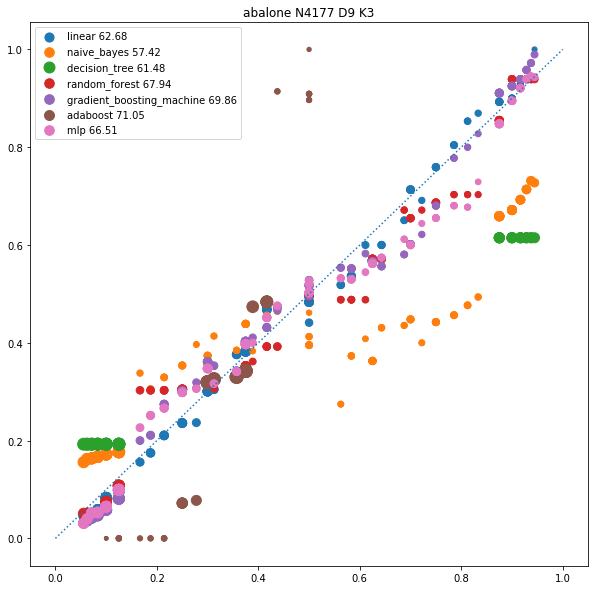

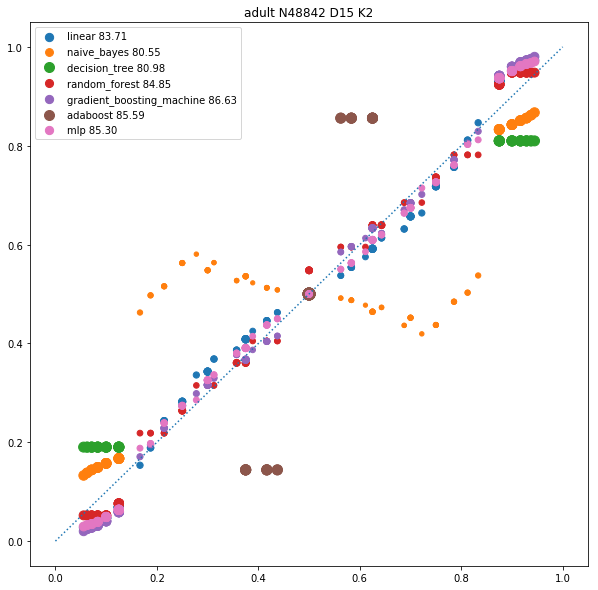

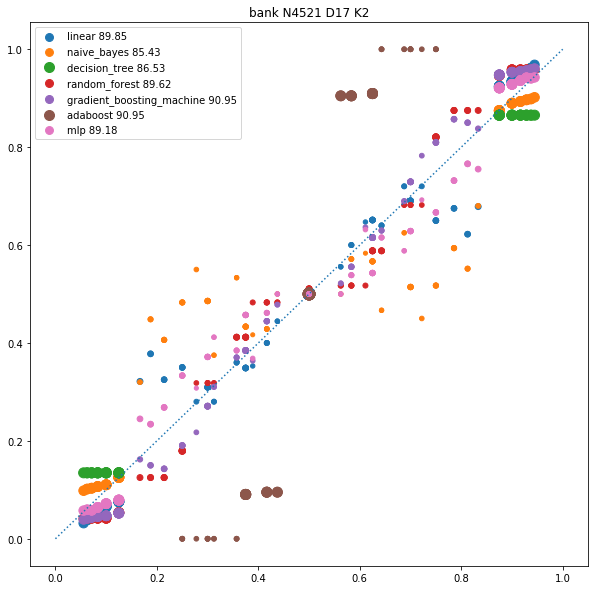

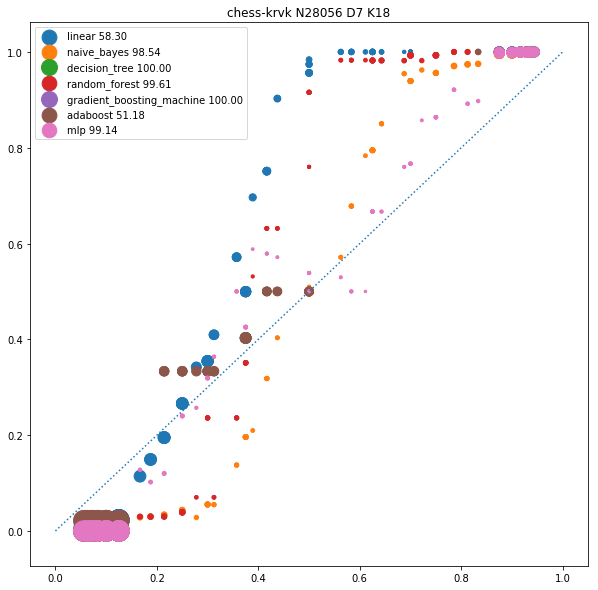

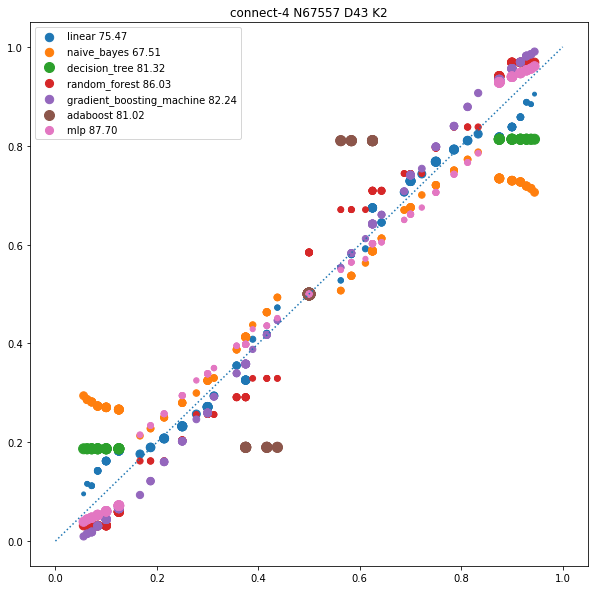

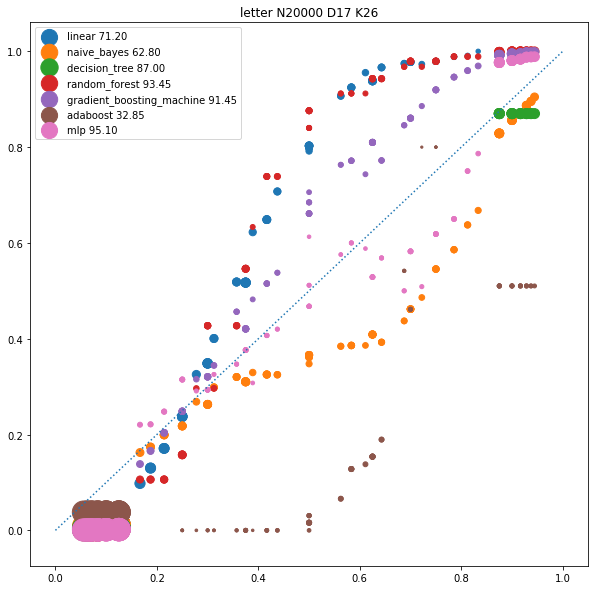

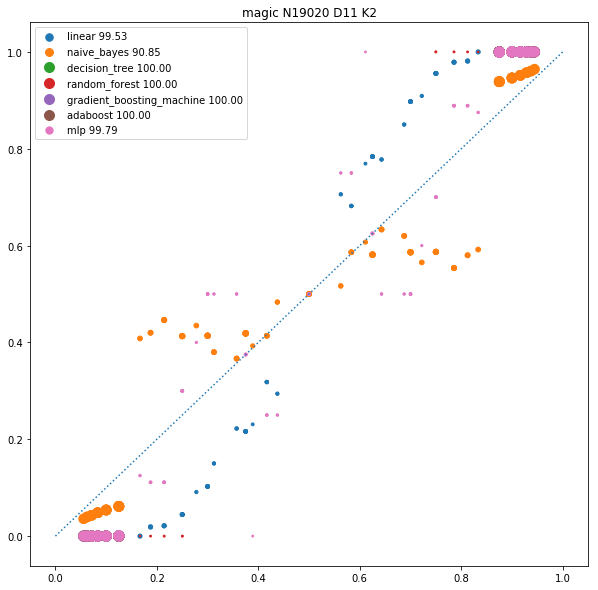

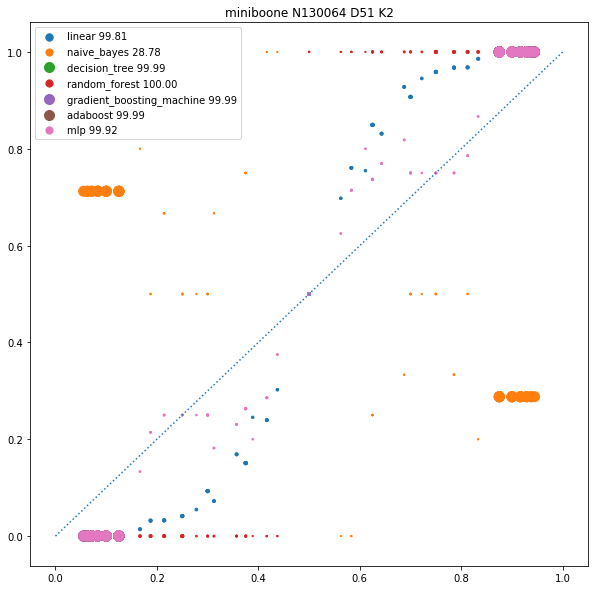

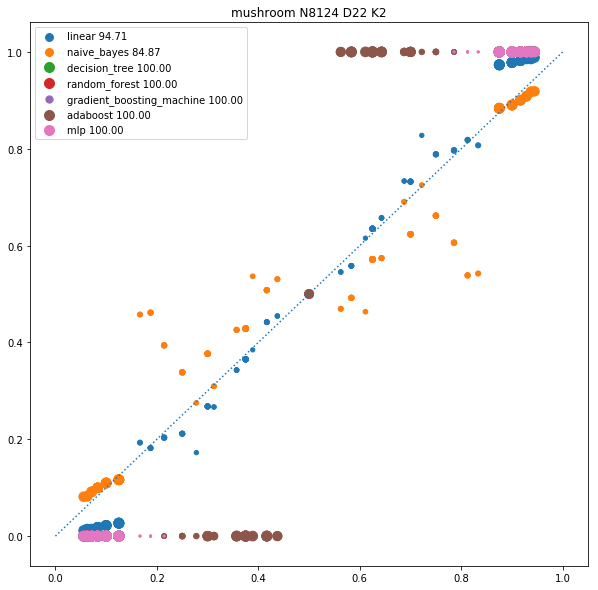

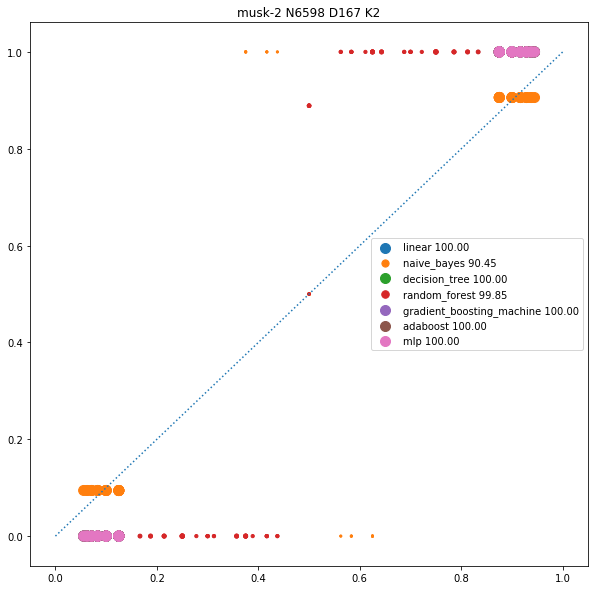

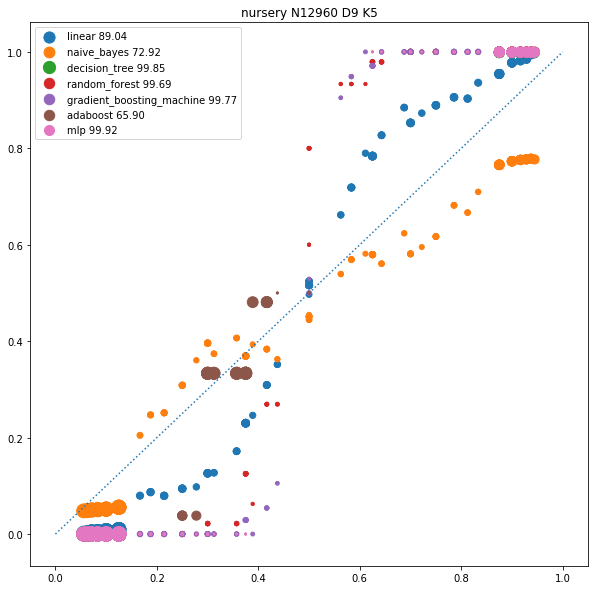

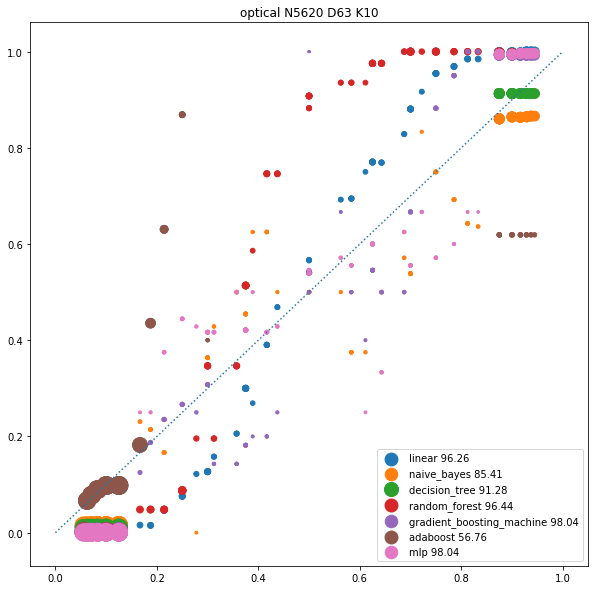

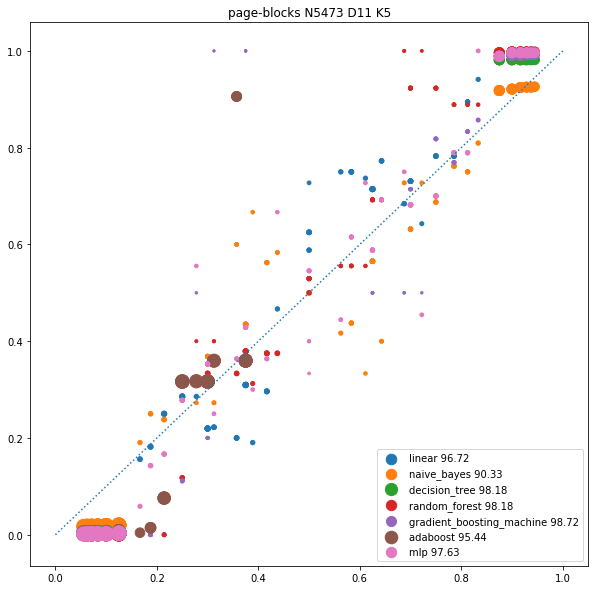

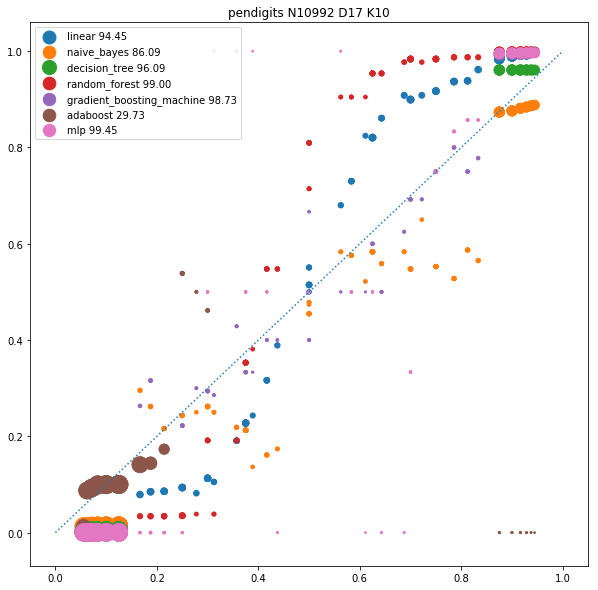

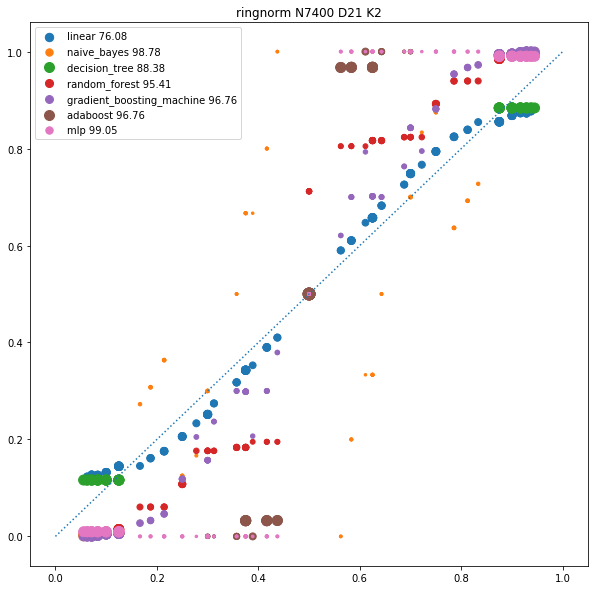

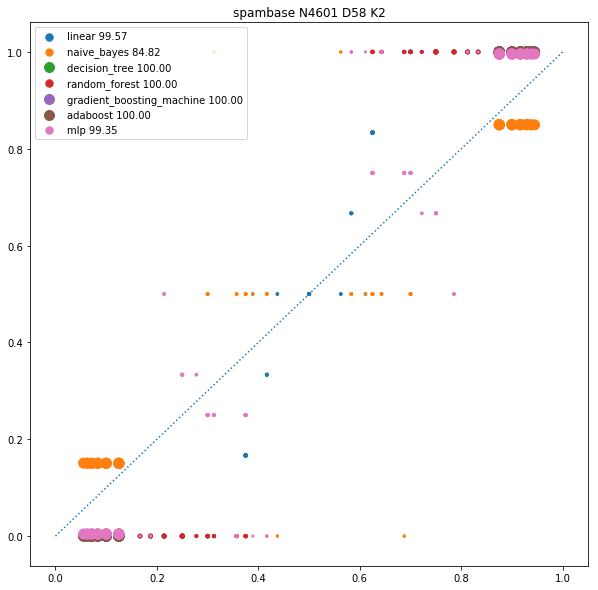

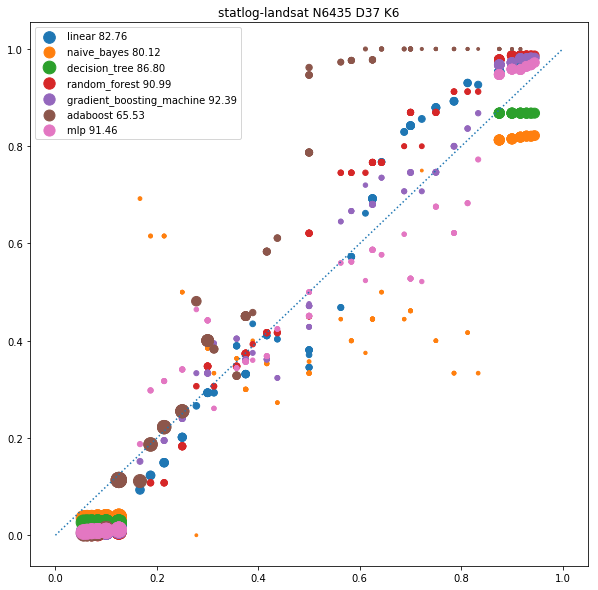

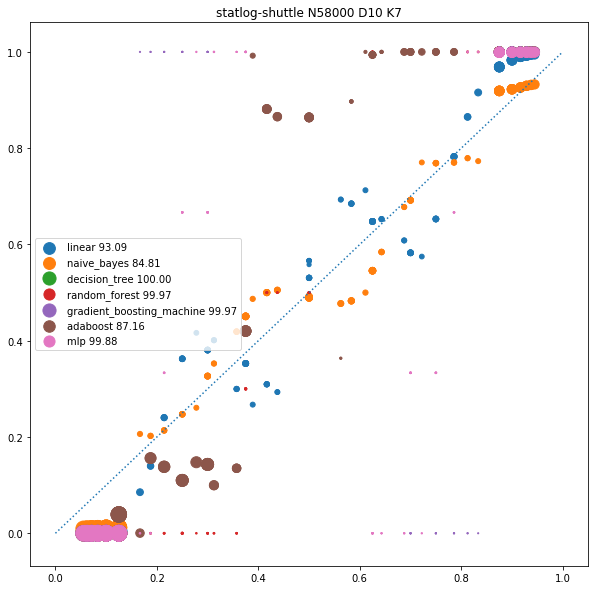

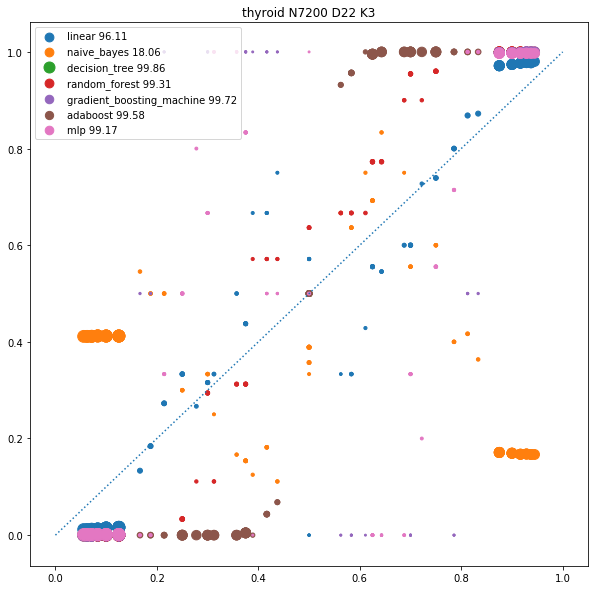

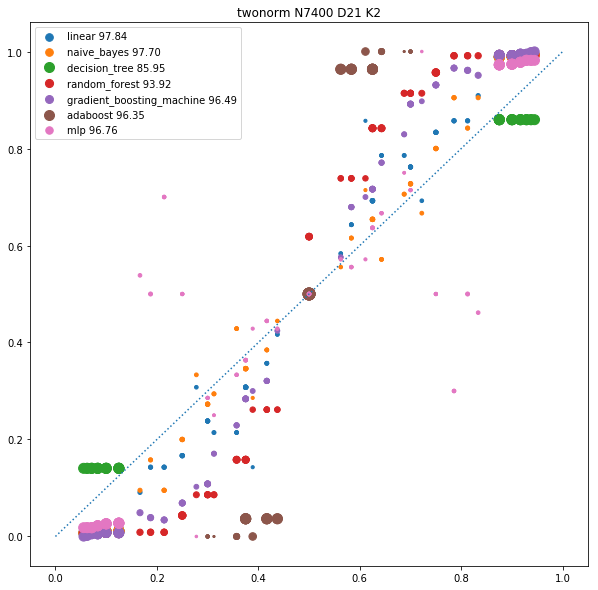

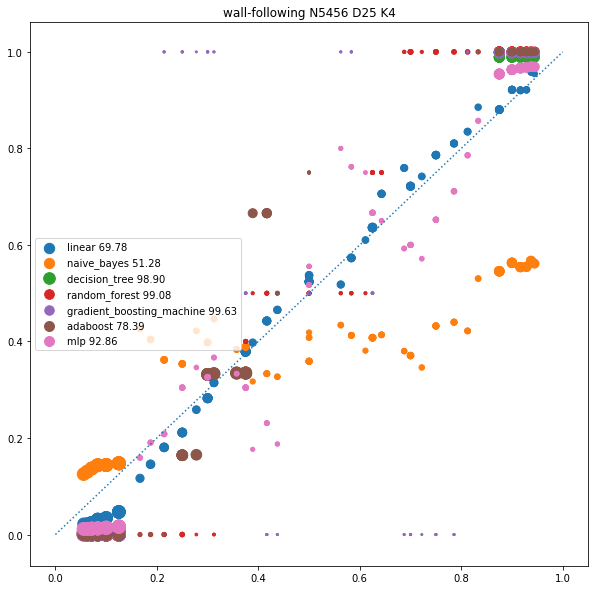

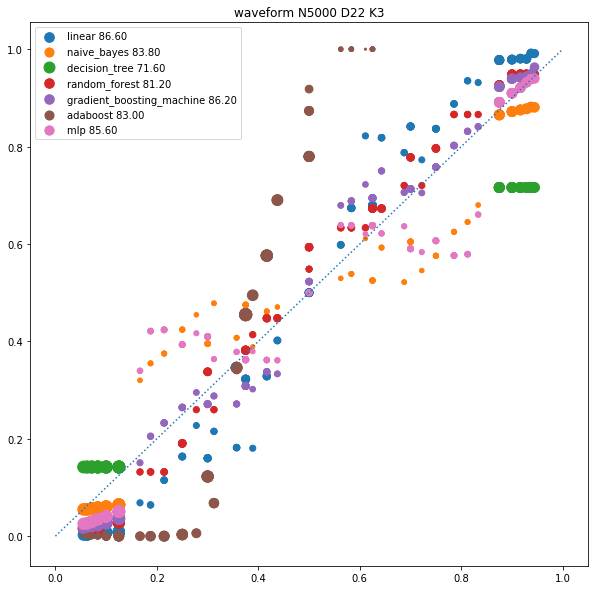

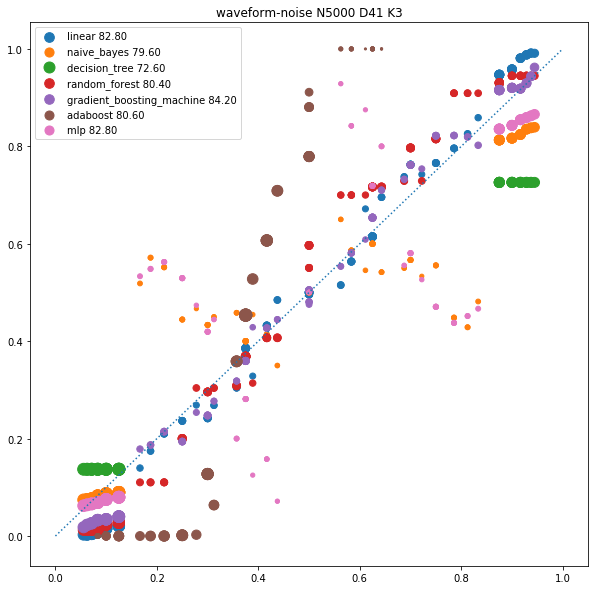

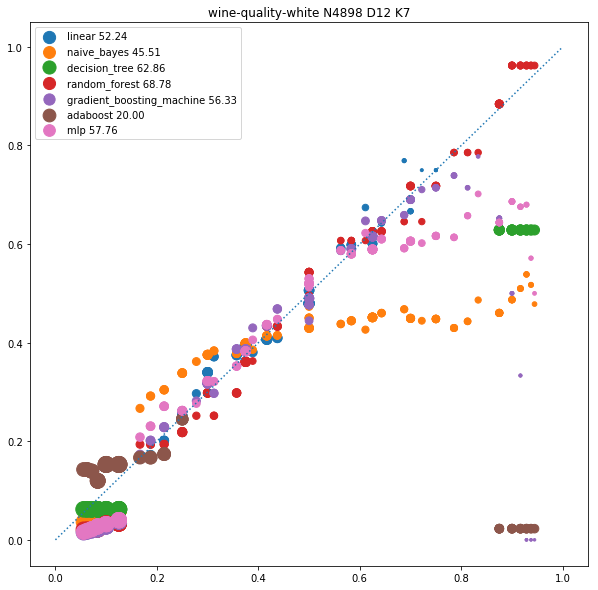

In [4]:
colours = ['C{}'.format(i) for i in range(10)]

for dataset in classification_datasets:
    d = get_classification_data(dataset)
    if d.N > 4000:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_title('{} N{} D{} K{}'.format(dataset, d.N, d.D, d.K))
        ax.plot([0, 1], [0, 1], linestyle=':')
        

        for model, colour in zip(models, colours):
            x, y, s = [], [], []

            res = read_results(dataset, model)

            Hs = [5, 6, 7, 8, 9, 10]
            key = True
            for H in Hs:
                bins = np.linspace(0, 1, H)
                if res:
                    Y, p = res
                    for bin_lower, bin_higher in zip(bins[:-1], bins[1:]):
                        ind = np.logical_and(np.less(p, bin_higher), np.greater(p, bin_lower))
                        n_bin = np.sum(ind.astype(float))
                        n_correct = np.sum(Y[ind]==1)
                        p_bin = np.average([bin_lower, bin_higher])
                        if n_bin > 0:
                            x.append(p_bin)
                            y.append(float(n_correct)/float(n_bin))
                            s.append(100*(float(n_bin)/float(len(Y)))**0.5)  # equal area 
                    acc = np.average((np.argmax(p, 1)==np.argmax(Y, 1)).astype(float))*100
                    
                    if key:
                        ax.scatter(x, y, s=s, label='{} {:.2f}'.format(model, acc), color=colour)
                    else:
                        ax.scatter(x, y, s=s, color=colour)
                    key = False
                        

        plt.legend()
        plt.show()